In [ ]:
pip install yfinance

In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
#get the stock quotestart = datetime(2018,8,1)
start = datetime(2013,8,10)
end_date = datetime.today().strftime('%Y-%m-%d')
stock = 'AAPL'
df = yf.download(stock,start = start, end = end_date)
#show the data
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-08-12,16.316429,16.737499,16.308214,16.691429,14.548296,364434000
2013-08-13,16.819286,17.666430,16.716070,17.484644,15.239666,881941200
2013-08-14,17.781429,18.008928,17.621429,17.803572,15.517640,756372400
2013-08-15,17.729286,17.942858,17.467142,17.782499,15.499269,490294000
2013-08-16,17.862499,17.962143,17.816429,17.940357,15.636859,362306000
...,...,...,...,...,...,...
2023-11-22,191.490005,192.929993,190.830002,191.309998,191.309998,39617700
2023-11-24,190.869995,190.899994,189.250000,189.970001,189.970001,24048300
2023-11-27,189.919998,190.669998,188.899994,189.789993,189.789993,40552600


In [ ]:
#get the number of rounds and columns in the data set
df.shape

(2594, 6)

<function matplotlib.pyplot.show(close=None, block=None)>

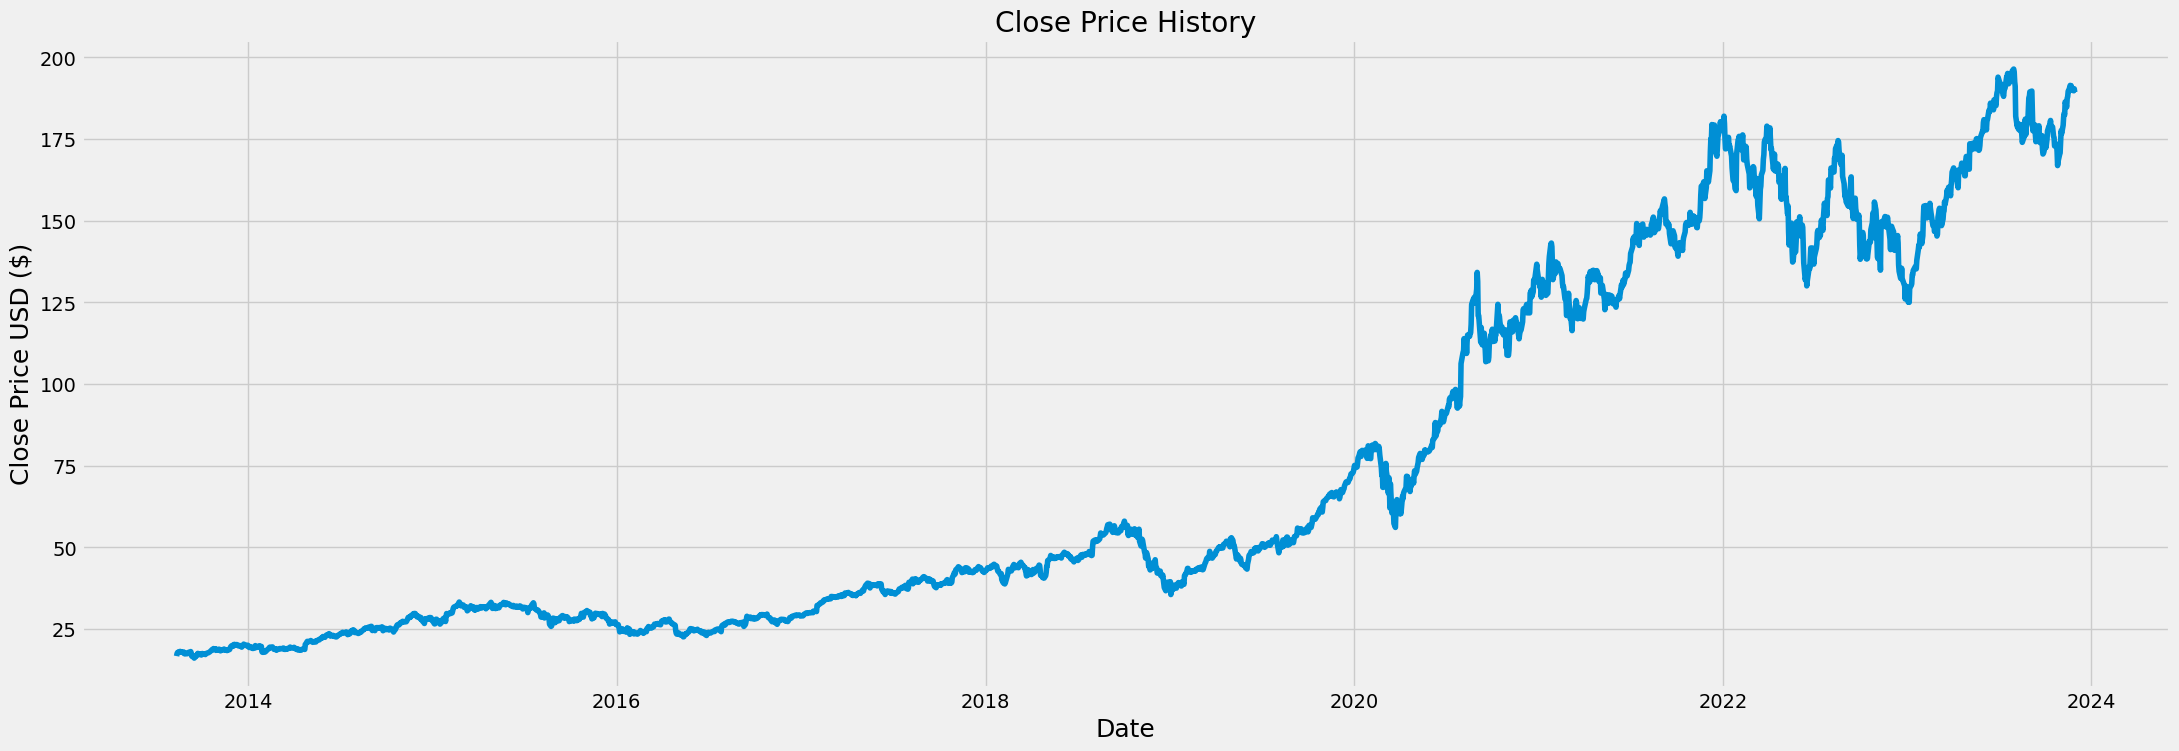

In [ ]:
#visualize the closing stock price history
plt.figure(figsize = (24,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show

In [ ]:
#create a new data frame with only "Close" column
data = df.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2076

In [16]:
#scale the data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00341354],
       [0.00781115],
       [0.00957929],
       ...,
       [0.96307676],
       [0.96645862],
       [0.96074827]])

In [17]:
#create the training dataset
#create the scaled training dataset
train_data = scaled_data[0:training_data_len, :]
#split the data into x-train and y-train dataset
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.00341354, 0.00781115, 0.00957929, 0.00946246, 0.01033763,
       0.01140882, 0.01008815, 0.01034358, 0.01046237, 0.01007825,
       0.01046436, 0.0076171 , 0.00807448, 0.00823288, 0.00734584,
       0.00761512, 0.0096169 , 0.00893974, 0.00952385, 0.01109795,
       0.008815  , 0.00348285, 0.00446889, 0.00292645, 0.        ,
       0.00102961, 0.0028829 , 0.00439166, 0.00342344, 0.008023  ,
       0.00771808, 0.00621921, 0.00714784, 0.00646077, 0.00527277,
       0.00749236, 0.00780916, 0.00659145, 0.00651622, 0.00745078,
       0.0061024 , 0.00722109, 0.007825  , 0.00845266, 0.0090922 ,
       0.00961493, 0.01009607, 0.01076729, 0.01163652, 0.0141056 ,
       0.01381057, 0.01481839, 0.0161945 , 0.0150164 , 0.01579256,
       0.01317894, 0.01480652, 0.01437091, 0.01384225, 0.01517282])]
[0.01491541458093805]

[array([0.00341354, 0.00781115, 0.00957929, 0.00946246, 0.01033763,
       0.01140882, 0.01008815, 0.01034358, 0.01046237, 0.01007825,
       0.01046436, 0.0076171 , 0.00

In [18]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [19]:
#reshape the data
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2016, 60, 1)

In [20]:
#build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [21]:
#compile the model
model.compile(optimizer ='adam', loss = 'mean_squared_error')

In [22]:
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

2016/2016 [==============================] - 77s 34ms/step - loss: 0.0011


In [23]:
#create the testing data set
#create a new array containing scaled values from index 2013 to 2591
test_data = scaled_data[training_data_len - 60 : , :]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])


In [24]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [25]:
#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))


In [26]:
#get the model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

17/17 [==============================] - 1s 18ms/step


In [27]:
#get the root mean square error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test)**2))
rmse

11.406135164869118

<ipython-input-28-0836c1e7be2b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid ['Predictions'] = predictions


<function matplotlib.pyplot.show(close=None, block=None)>

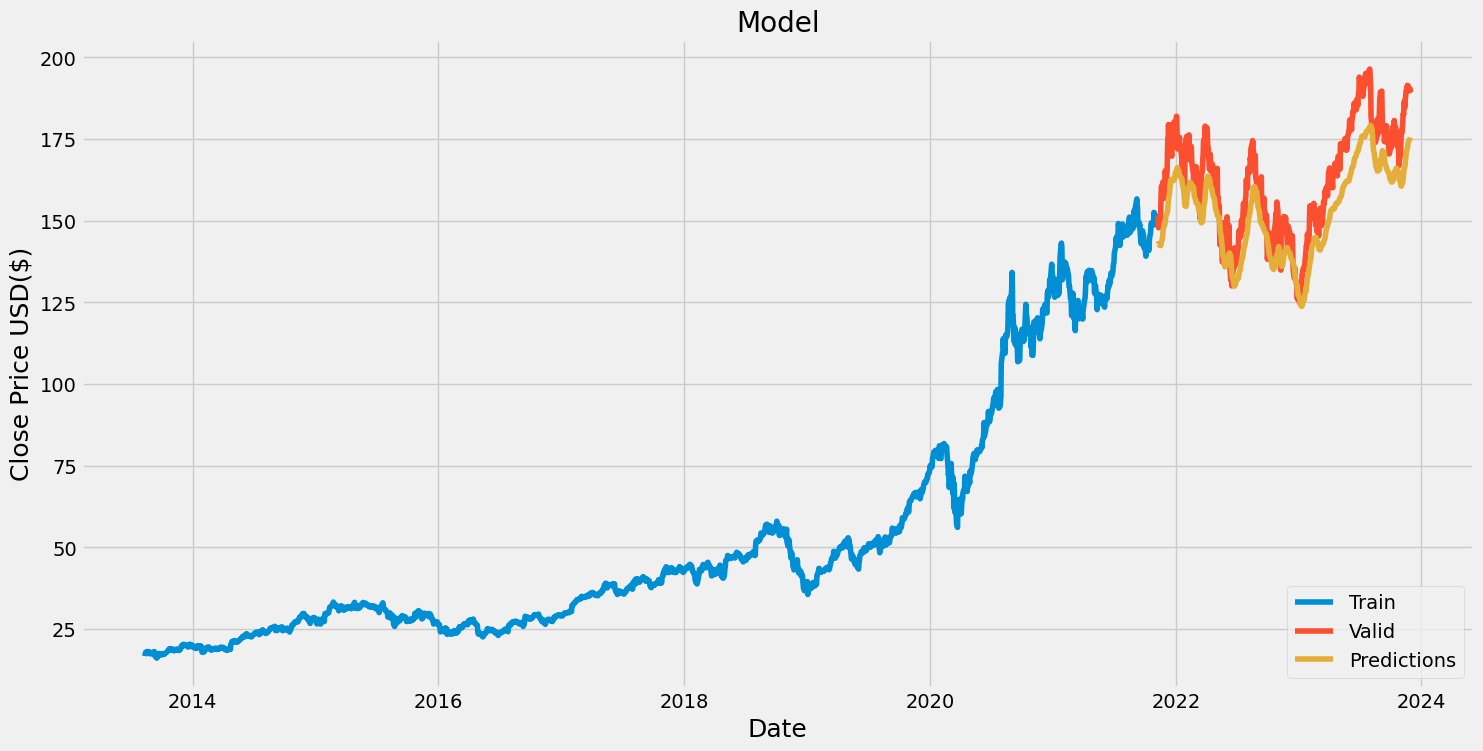

In [28]:
#Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid ['Predictions'] = predictions
#visualize the data
plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD($)', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc = 'lower right')
plt.show

In [29]:
#show the valid and predicted prices
valid

,Close,Predictions
Date,,
2021-11-08,150.440002,142.754242
2021-11-09,150.809998,142.883362
2021-11-10,147.919998,142.986832
2021-11-11,147.869995,142.852264
2021-11-12,149.990005,142.603409
...,...,...
2023-11-22,191.309998,173.785339
2023-11-24,189.970001,174.471573
2023-11-27,189.789993,174.942444
